## Imports


In [169]:
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
import torch.onnx
import torch.nn as nn
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data mining

In [170]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")


In [171]:
df.shape

(4898, 12)

In [172]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### Check if there are any NaN values

In [174]:
print(df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [175]:
fig = px.histogram(df,x='quality')
fig.show()

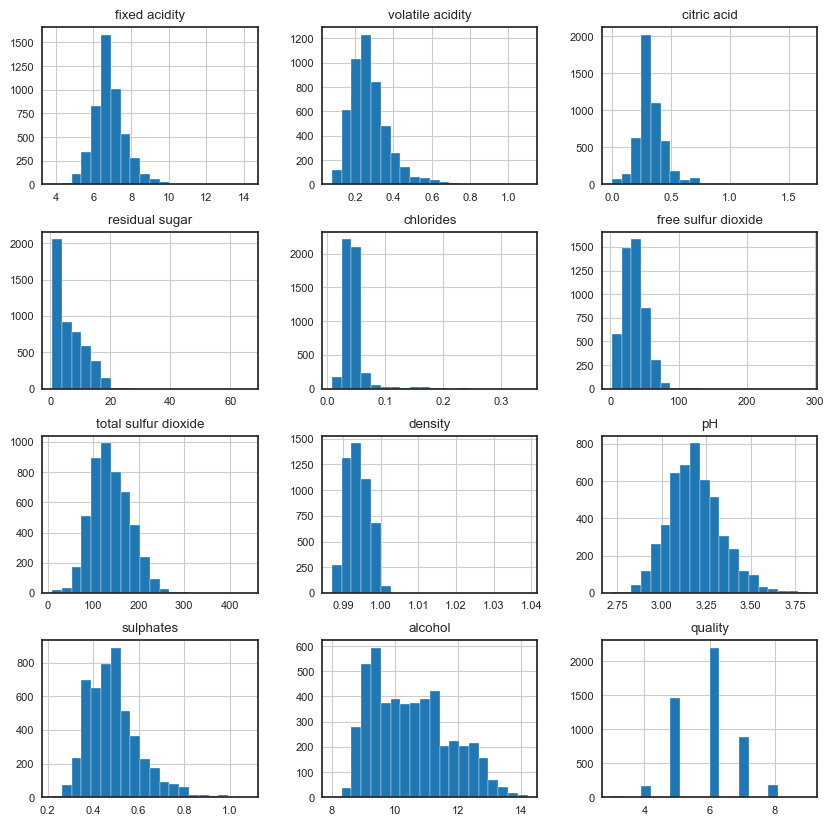

In [176]:

df.hist(bins=20, figsize=(10, 10))
plt.show()

<AxesSubplot:>

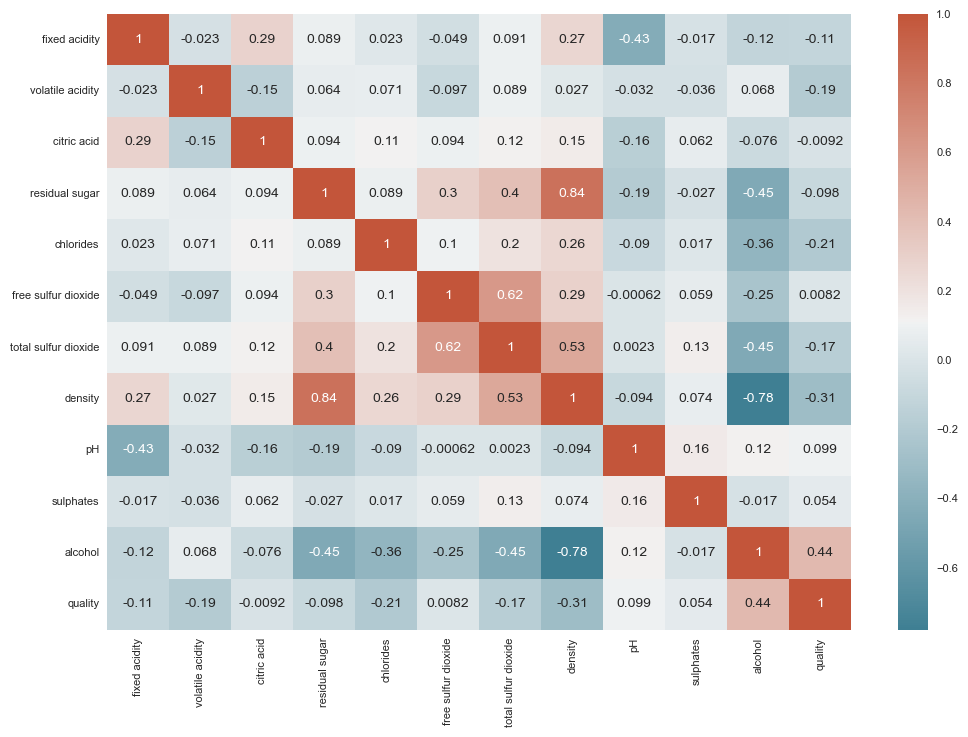

In [177]:
corr = df.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [178]:
# train=df.sample(frac=0.8,random_state=200) #random state is a seed value
# test=df.drop(train.index)
# x_train = train.values[:,:-1]
# y_train = train.values[:,-1]
# x_test = test.values[:,:-1]
# y_test = test.values[:,-1]

In [179]:
x = df.values[:,:-1]
y = df.values[:,-1]
x_norm = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, train_size=0.8, random_state=200)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=200) # 0.25 x 0.8 = 0.2

# xy = df.to_numpy()
# xy_norm = StandardScaler().fit_transform(xy)
# x= xy_norm[:,:-1]
# y= xy_norm[:,-1]
# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=200)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=200) # 0.25 x 0.8 = 0.2


In [180]:
x_val.shape, y_val.shape

((980, 11), (980,))

In [181]:
y_val.reshape(-1, 1)

array([[7.],
       [6.],
       [5.],
       [6.],
       [6.],
       [5.],
       [6.],
       [5.],
       [7.],
       [5.],
       [5.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [7.],
       [5.],
       [6.],
       [5.],
       [5.],
       [6.],
       [7.],
       [7.],
       [6.],
       [5.],
       [6.],
       [7.],
       [6.],
       [6.],
       [7.],
       [9.],
       [5.],
       [5.],
       [7.],
       [5.],
       [6.],
       [5.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [7.],
       [6.],
       [5.],
       [7.],
       [7.],
       [7.],
       [7.],
       [5.],
       [5.],
       [6.],
       [6.],
       [6.],
       [7.],
       [6.],
       [7.],
       [5.],
       [5.],
       [5.],
       [5.],
       [6.],
       [8.],
       [7.],
       [5.],
       [7.],
       [7.],
       [7.],
       [6.],
       [4.],
       [6.],
       [6.],

In [182]:
val = np.concatenate((x_val, y_val.reshape(-1, 1)), axis=1)
pd.DataFrame(val).to_csv("valid.csv", index=False)

In [183]:
train_dataset = data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
train_data_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [184]:
test_dataset = data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
test_data_loader = data.DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [185]:
data_loaders = {'train': train_data_loader, 'test':test_data_loader}
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fed4a1f2e50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fed4a1f2250>}

In [186]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.activ_func = nn.LeakyReLU()
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.linear3 = nn.Linear(num_hidden, num_hidden)
        self.linear4 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ_func(x)
        x = self.linear2(x)
        x = self.activ_func(x)
        x = self.linear3(x)
        x = self.activ_func(x)
        x = self.linear4(x)

        return x

In [187]:
def train_model(model, data_loaders, loss_module, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {}
    training_loss, training_acc, test_loss, test_acc = [], [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}:")
        for phase in ['train', 'test']:
            if phase =='train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corretcs = 0

            for inputs, targets in data_loaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    predictions = model(inputs.float())
                    predictions = predictions.squeeze(dim=1)
                    loss = loss_module(predictions, targets.float())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                predictions = torch.round(predictions)
                running_corretcs += torch.sum(predictions == targets)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = running_corretcs.double() / len(data_loaders[phase].dataset)
            if phase == 'train':
                training_loss.append(epoch_loss)
                training_acc.append(epoch_acc)
            else:
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc*100:2f} %')
    history.update({'training_loss' : training_loss, 'training_acc': training_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [188]:
model = SimpleClassifier(num_inputs=11, num_hidden=256, num_outputs=1)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_module = nn.MSELoss()

In [189]:
_, history = train_model(model, data_loaders, loss_module, optimizer, scheduler, num_epochs=100)

Epoch 0:
train Loss: 3.4417 Acc: 0.3033
test Loss: 0.7833 Acc: 0.4582
Epoch 1:
train Loss: 0.6579 Acc: 0.4986
test Loss: 0.5796 Acc: 0.5184
Epoch 2:
train Loss: 0.5509 Acc: 0.5187
test Loss: 0.5491 Acc: 0.5265
Epoch 3:
train Loss: 0.5190 Acc: 0.5449
test Loss: 0.5276 Acc: 0.5265
Epoch 4:
train Loss: 0.5101 Acc: 0.5415
test Loss: 0.5294 Acc: 0.5255
Epoch 5:
train Loss: 0.5001 Acc: 0.5470
test Loss: 0.5126 Acc: 0.5388
Epoch 6:
train Loss: 0.4775 Acc: 0.5551
test Loss: 0.4841 Acc: 0.5724
Epoch 7:
train Loss: 0.4668 Acc: 0.5517
test Loss: 0.5360 Acc: 0.5480
Epoch 8:
train Loss: 0.4500 Acc: 0.5613
test Loss: 0.4844 Acc: 0.5429
Epoch 9:
train Loss: 0.4424 Acc: 0.5793
test Loss: 0.4841 Acc: 0.5296
Epoch 10:
train Loss: 0.4383 Acc: 0.5779
test Loss: 0.4660 Acc: 0.5561
Epoch 11:
train Loss: 0.4158 Acc: 0.5793
test Loss: 0.4728 Acc: 0.5714
Epoch 12:
train Loss: 0.4040 Acc: 0.5892
test Loss: 0.4952 Acc: 0.5592
Epoch 13:
train Loss: 0.4139 Acc: 0.5851
test Loss: 0.4665 Acc: 0.5684
Epoch 14:
train 

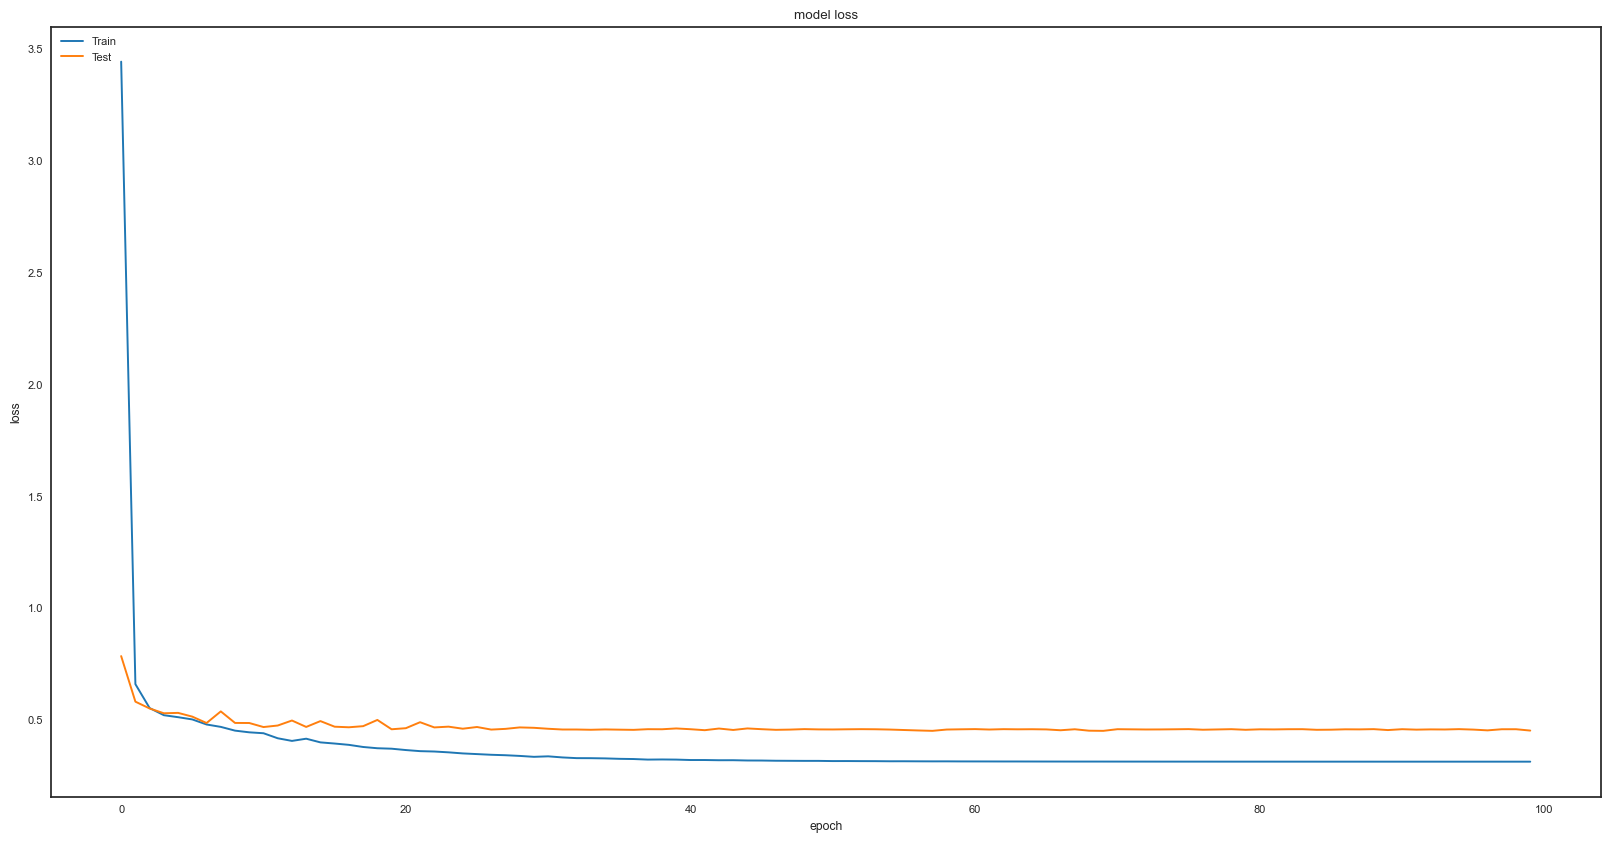

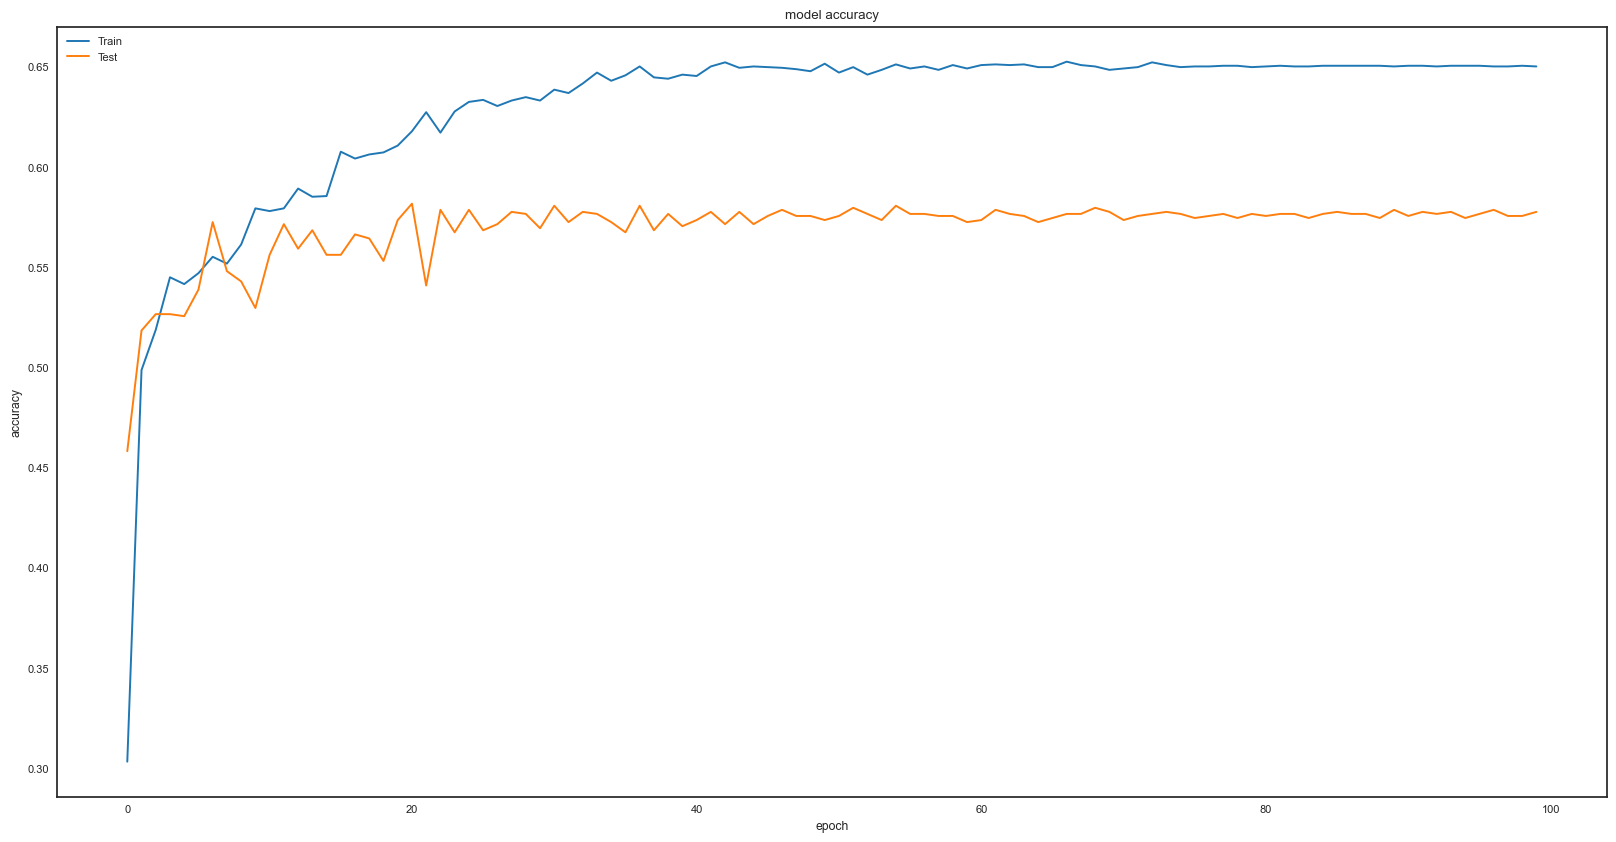

In [190]:
def my_plot(history):
    plt.figure(figsize=(20, 10))
    # plt.style.use("seaborn-paper")
    # summarize history for loss
    plt.plot(np.arange(len(history['training_loss'])),history['training_loss'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
     # summarize history for accuracy
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(len(history['training_loss'])),history['training_acc'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

my_plot(history)

In [191]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [192]:
# state_dict = model.state_dict()
# print(state_dict)

In [193]:
# torch.save(state_dict, "wine1.tar")

In [194]:
# # Load state dict from the disk (make sure it is the same name as above)
# state_dict = torch.load("wine1.tar")
#
# # Create a new model and load the state
# new_model = SimpleClassifier(num_inputs=11, num_hidden=16, num_outputs=1)
# new_model.load_state_dict(state_dict)
#
# # Verify that the parameters are the same
# print("Original model\n", model.cpu().state_dict())
# print("\nLoaded model\n", new_model.state_dict())

In [195]:
batch_size = 10
onnx_input = torch.randn(batch_size, 11)
expected_label = 6.

In [196]:
input_names = df.columns[:-1]
output_names = df.columns[-1]
print(input_names, output_names)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object') quality


In [197]:
torch.onnx.export(model, onnx_input, 'wine_model.onnx', export_params=True, input_names=['input'], output_names=['output'])